# Modern portfolio theory of H. Markowitz

Modern portfolio theory is a practical method of selecting investments to maximise their overall return within an acceptable level of risk. This mathematical framework is used to construct a portfolio of investments that maximises the amount of expected return for a given level of collective risk — portfolio risk.

A key element of the LMP is diversification. Most investments are either high risk/high return or low risk/low return. According to Markowitz, investors can achieve the best results by choosing an optimal combination of these two types of investments based on an assessment of their individual risk tolerance.

In portfolio optimization we have some amount of money to invest in any of $n$ different assets. <br>
We choose what fraction $w_i$ of our money to invest in each asset $i$, $i=1, \ldots, n$.<br>
We call $w\in {\bf R}^n$ the **_portfolio allocation vector_**.<br>
We of course have the constraint that ${\mathbf 1}^T w =1$.
The allocation $w_i<0$ means a **short position** in asset $i$, or that we borrow shares to sell now that we must replace later.
The allocation $w \geq 0$ is a _long only_ portfolio.
The quantity
$$ \|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w\_- $$
is known as _leverage_.

- Expected return: $$\mathbb{E}(r_p)=w^T\space \mathbb{E}(r) = \sum^{n}_{i=1}w_i\mathbb{E}(r_i)$$
- Risk (Annualized volatility $\sigma$ ) : $$\sigma^2_p=\sum^{n}_{i=1}\sum^{n}_{j=1}w_i\times w_j\times cov(r_i,r_j)$$
- The Sharpe Ratio from the CAPM: $$S_p=\frac{\mathbb{E}(r_p-r_f)}{\sigma_p}\space\text{basically}\space S_p=\frac{\mathbb{E}(r_p)-r_{f_{annualized}}}{\sigma_p}$$


In [1]:
from warnings import filterwarnings

filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

from quant_invest_lab.portfolio import (
    MonteCarloPortfolio,
    ConvexPortfolio,
    RiskParityPortfolio,
)
from quant_invest_lab.utils import get_cac40_symbols
from quant_invest_lab.data_provider import (
    build_multi_crypto_dataframe,
    download_crypto_historical_data,
)

Loading BokehJS ...

In [2]:
MININUM_HISTORY_YEAR = 2
N = 365
# get_list_of_symbols()
symbols = set(
    [
        "ROSE-USDT",
        "AVAX-USDT",
        "UNI-USDT",
        "ATOM-USDT",
        "ICP-USDT",
        "THETA-USDT",
        "VET-USDT",
        "DOGE3S-USDT",
        "BNB-USDT",
        "NEAR-BTC",
        "BTC-USDT",
        "NEAR-USDT",
        "SOLVE-BTC",
        "ETH-USDT",
        "KDA-USDT",
        "SOL-USDT",
        "EGLD-USDT",
        "ALGO-USDT",
        "FTM-USDT",
        "AXS-USDT",
        "ADA-USDT",
        "NKN-USDT",
        "LOOM-BTC",
        "LTC3L-USDT",
        "XPR-USDT",
    ]
)


closes = build_multi_crypto_dataframe(symbols)

cols_to_remove = [
    col
    for col, nans in closes.isna().sum().items()
    if len(closes) - nans < int(N * MININUM_HISTORY_YEAR)
]


closes.drop(columns=cols_to_remove, inplace=True)
returns = closes.pct_change().dropna()
log_returns = np.log(closes).pct_change().dropna()
returns.head()

Fetching symbols...: 100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


,FTM-USDT_Close,ETH-USDT_Close,XPR-USDT_Close,ROSE-USDT_Close,KDA-USDT_Close,BTC-USDT_Close,BNB-USDT_Close,AXS-USDT_Close,LTC3L-USDT_Close,LOOM-BTC_Close,...,THETA-USDT_Close,ALGO-USDT_Close,ICP-USDT_Close,AVAX-USDT_Close,NEAR-USDT_Close,SOLVE-BTC_Close,NEAR-BTC_Close,ATOM-USDT_Close,VET-USDT_Close,SOL-USDT_Close
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-25 02:00:00,0.037287,0.017891,-0.043121,0.044651,0.067293,0.027709,0.066640,0.036219,0.062903,0.075829,...,0.020619,0.022893,0.049966,-0.168885,0.107901,0.000000,0.077286,0.026370,0.052390,0.019919
2021-08-26 02:00:00,-0.131195,-0.041898,-0.118026,-0.070689,-0.083942,-0.043968,-0.050108,-0.040360,-0.170724,-0.030837,...,-0.095215,-0.067895,-0.090032,-0.104534,-0.130046,-0.079787,-0.090989,-0.105399,-0.092411,0.037795
2021-08-27 02:00:00,0.136630,0.058336,0.029197,0.085536,0.165407,0.047504,0.034101,0.058530,0.148065,-0.022727,...,0.065222,0.073850,0.108127,0.211650,0.091253,0.000000,0.043311,0.140108,0.105449,0.178374
2021-08-28 02:00:00,0.061920,-0.008557,0.054374,-0.020706,-0.022751,-0.003345,-0.017017,0.014625,-0.022560,-0.009302,...,-0.003769,-0.024803,0.038106,0.000519,0.069754,0.011561,0.073801,0.041734,-0.037458,0.090503
2021-08-29 02:00:00,0.119219,-0.006362,-0.035874,0.056676,-0.023040,-0.002594,-0.012709,0.047738,0.000000,-0.018779,...,-0.000823,-0.015222,0.106282,-0.055146,-0.023781,0.005714,-0.024055,-0.005399,0.002407,-0.018144


# Rolling portfolio rebalance


In [ ]:
from quant_invest_lab.types import PortfolioMetric
from tqdm import tqdm
from typing import Literal

In [10]:
from typing import Iterable, Literal, Optional
import pandas as pd
import numpy as np
import numpy.typing as npt
import numpy.linalg as linalg
import plotly.graph_objects as go
from tqdm import tqdm
from abc import ABC, abstractmethod
from scipy.optimize import minimize
from quant_invest_lab.constants import PORTFOLIO_METRICS, TIMEFRAME_ANNUALIZED

from quant_invest_lab.reports import (
    construct_report_dataframe,
    plot_from_trade_df_and_ptf_optimization,
    print_portfolio_strategy_report,
)
from quant_invest_lab.types import PortfolioMetric, Timeframe


class ABCPortfolio(ABC):
    def __init__(
        self,
        returns: pd.DataFrame,
        benchmark_returns: pd.Series,
        timeframe: Timeframe = "1hour",
    ) -> None:
        """Construct a new 'ABCPortfolio' object. Generic for all portfolio optimization models : `MonteCarloPortfolio`, `ConvexPortfolio`.

        Args:
        -----
            returns (pd.DataFrame): The returns of the assets in the portfolio.

            benchmark_returns (pd.Series): The returns of the portfolio's benchmark.

            timeframe (Timeframe, optional): The timeframe granularity of the returns and the benchmark_returns, it must be the same. Defaults to "1hour".
        """
        self._returns = returns
        self._benchmark_returns = benchmark_returns
        self._returns_mean = self._returns.mean()
        self._returns_cov = self._returns.cov().values
        self._timeframe = timeframe
        self._trading_days = TIMEFRAME_ANNUALIZED[self._timeframe]
        self._already_optimized = False
        self._optimized_weights = None

    @abstractmethod
    def fit(self):
        pass

    @abstractmethod
    def rolling_backtest(self):
        pass

    def get_allocation(self, get_allocation_only: bool = True) -> pd.DataFrame:
        """Plot the allocation of the portfolio and return a DataFrame with the allocation of each asset. This function can't be called before the fit method.

        Args:
        -------
            get_allocation_only (bool, optional): Whether or not to only return the allocation DataFrame. Defaults to True.
        Returns:
        --------
            pd.DataFrame: The allocation of each asset in the portfolio, columns are the assets and rows are the weights.
        """
        assert (
            self._already_optimized
        ), "You must fit the model before getting the allocation."

        allocation_dataframe = pd.DataFrame(
            {
                p: [w]
                for p, w in zip(
                    self._returns.columns,
                    self._optimized_weights,
                )
            }
        )
        if get_allocation_only is True:
            return allocation_dataframe

        print_portfolio_strategy_report(
            self._returns.apply(
                lambda row_returns: row_returns @ self._optimized_weights, axis=1
            ),
            self._benchmark_returns,
            self._timeframe,
        )

        plot_from_trade_df_and_ptf_optimization(
            self._returns.apply(
                lambda row_returns: row_returns @ self._optimized_weights, axis=1
            ),
            self._benchmark_returns,
            allocation_dataframe,
        )
        return allocation_dataframe

    def _compute_metrics(
        self,
        weights: npt.NDArray,
    ) -> dict[PortfolioMetric, float | int]:
        """Given an array of weights, compute the Sharpe ratio, the risk and the return of the portfolio. This method in used it the optimization functions of the portfolio optimization models.

        Args:
        -----
            weights (npt.NDArray): The weights of the assets in the portfolio.

        Returns:
        -----
            dict[PortfolioMetric, float | int]: The ratios, the risk, the return all the metrics related to the portfolio.
        """
        # ret = float(np.sum(self._returns_mean * weights * self._trading_days))  # type: ignore
        rets = self._returns.apply(lambda row_returns: row_returns @ weights, axis=1)
        report_df = construct_report_dataframe(rets, self._benchmark_returns)

        co = pd.DataFrame(self._returns.values * weights).corr()
        np.fill_diagonal(co.values, 1)
        co.fillna(0, inplace=True)
        div = float(linalg.norm(co - np.eye(co.shape[1]), ord="fro"))

        return report_df["Portfolio"].T.to_dict()


class RiskParityPortfolio(ABCPortfolio):
    def __compute_objective_metrics(self, weights: npt.NDArray, args: list) -> float:
        """The objective function to optimize. It is used in the `fit` method.

        Args:
        -----
            weights (npt.NDArray): The weights of the assets in the portfolio.

            args (list): The arguments of the objective function.

        Returns:
        -----
            float: The value of the objective function.
        """

        # We convert the weights to a matrix
        weights_matrix = np.matrix(weights)
        assets_risk_budget = np.matrix(args[0])

        if args[1] != "Expected volatility":
            raise NotImplementedError(
                "Only 'Expected volatility' is implemented for now."
            )

        # We calculate the risk of the weights distribution
        portfolio_risk = self._compute_metrics(weights=weights)[args[1]]

        # We calculate the contribution of each asset to the risk of the weights
        # distribution
        assets_risk_contribution = (
            np.multiply(
                weights_matrix.T,
                self._returns_cov * self._trading_days * weights_matrix.T,
            )
            / portfolio_risk
        )

        # We calculate the desired contribution of each asset to the risk of the weights distribution
        assets_risk_target = portfolio_risk * assets_risk_budget

        # Error between the desired contribution and the calculated contribution of each asset
        return np.sum(np.square(assets_risk_contribution - assets_risk_target.T))  # MSE

    def fit(
        self,
        parity_risk_metric: Literal[
            "Expected volatility",
            "VaR",
            "CVaR",
            "Specific risk",
            "Portfolio beta",
            "Tracking error",
        ] = "Expected volatility",
    ) -> None:
        """Optimize the portfolio for an equity risk parity among assets. It uses an optimizer from `scipy.optimize` module. This method returns nothing.

        Args:
            parity_risk_metric (Literal[ &quot;Expected volatility&quot;, &quot;VaR&quot;, &quot;CVaR&quot;, &quot;Specific risk&quot;, &quot;Portfolio beta&quot;, &quot;Tracking error&quot;, ]): The metric to use to compute the risk parity among assets. It can be one of the following: `Expected volatility`, `VaR`, `CVaR`, `Specific risk`, `Portfolio beta`, `Tracking error`. Default to `Expected volatility`.

        """
        cons = (
            {
                "type": "eq",
                "fun": lambda weights: np.sum(weights) - 1,
            },  # return 0 if sum of the weights is 1
            {"type": "ineq", "fun": lambda x: x},  # Long only
        )

        bounds = tuple([(0.0, 1.0) for _ in range(len(self._returns.columns))])
        init_guess = [
            1 / len(self._returns.columns) for _ in range(len(self._returns.columns))
        ]

        assets_risk_budget = [
            1 / len(self._returns.columns) for _ in range(len(self._returns.columns))
        ]

        opt_results = minimize(
            fun=self.__compute_objective_metrics,
            x0=init_guess,
            args=[assets_risk_budget, parity_risk_metric],
            method="SLSQP",
            bounds=bounds,
            constraints=cons,
            tol=1e-10,
        )

        self._already_optimized = True
        self._optimized_weights = opt_results.x


class ConvexPortfolio(ABCPortfolio):
    def __compute_objective_metrics(
        self, weights: npt.NDArray, args: list[str]
    ) -> float:
        """The objective function to optimize. It is used in the `fit` method.

        Args:
        -----
            weights (npt.NDArray): The weights of the assets in the portfolio.

            args (list[str]): The arguments of the objective function.

        Returns:
        -----
            float: The value of the objective function.
        """
        metric: PortfolioMetric = args[0]  # type: ignore
        way: Literal["min", "max"] = args[1]  # type: ignore
        metrics = self._compute_metrics(weights)
        return -metrics.get(metric, 0.0) if way == "max" else metrics.get(metric, 0.0)

    def rolling_backtest(
        self,
        metric: PortfolioMetric = "Sharpe ratio",
        way: Literal["min", "max"] = "max",
        max_asset_weight: float = 0.3,
        min_asset_weight: float = 0.0,
        backward_window: int = 365,
        rebalance_period: int = 30,
        optimize_with_full_memory: bool = False,
        get_all_allocations: bool = False,
    ) -> [pd.DataFrame, pd.DataFrame]:
        assert (
            self._returns.shape[0] == self._benchmark_returns.shape[0]
        ), "Error, raw_returns and benchmark_returns must have the same length"
        assert (
            self._returns.shape[0] > backward_window
        ), "Error, raw_returns must have more rows than backward_window"
        assert (
            self._returns.shape[0] > rebalance_period
        ), "Error, raw_returns must have more rows than rebalance_period"

        allocations = {}
        rebalancing = rebalance_period
        ptf_returns = pd.DataFrame(
            index=self._returns.index, columns=["portfolio_returns"]
        )

        for index, row in tqdm(
            self._returns.iloc[backward_window:].iterrows(),
            total=self._returns.iloc[backward_window:].shape[0],
        ):
            i = self._returns.index.get_loc(index)
            if rebalancing == rebalance_period:
                if optimize_with_full_memory is True:
                    ptf = ConvexPortfolio(
                        self._returns.iloc[:i],
                        self._benchmark_returns.iloc[:i],
                        self._timeframe,
                    )
                else:
                    ptf = ConvexPortfolio(
                        self._returns.iloc[i - backward_window : i],
                        self._benchmark_returns.iloc[i - backward_window : i],
                        self._timeframe,
                    )
                ptf.fit(metric, way, max_asset_weight=max_asset_weight, min_asset_weight=min_asset_weight)  # type: ignore
                current_weights = ptf.get_allocation()
                if get_all_allocations is True:
                    allocations[index] = current_weights
                ptf_returns.loc[index, "portfolio_returns"] = (current_weights.to_numpy() @ row.to_numpy())[0]  # type: ignore
                rebalancing = 0
            else:
                ptf_returns.loc[index, "portfolio_returns"] = (current_weights.to_numpy() @ row.to_numpy())[0]  # type: ignore
                rebalancing += 1

        # allocations = pd.DataFrame(
        #     tuple(map(lambda x: x.values[0], allocations.values())),
        #     index=allocations.keys(),
        #     columns=tuple(allocations.values())[0].columns,
        # )
        return ptf_returns #, allocations

    def fit(
        self,
        metric: PortfolioMetric = "Sharpe ratio",
        way: Literal["min", "max"] = "max",
        max_asset_weight: float = 0.3,
        min_asset_weight: float = 0.0,
    ) -> None:
        """Optimize the portfolio using the Sharpe ratio, risk or return as a metric and a maximization or a minimization this metric. It uses an optimizer from `scipy.optimize` module. This method returns nothing.

        Args:
        -----
            metric (Literal[ &quot;Expected return&quot;, &quot;Expected volatility&quot;, &quot;Skewness&quot;, &quot;Kurtosis&quot;, &=quot;VaR&quot;, &quot;CVaR&quot;, &quot;Max drawdown&quot;, &quot;Kelly criterion&quot;, &quot;Sharpe ratio&quot;, &quot;Sortino ratio&quot;, &quot;Burke ratio&quot;, &quot;Calmar ratio&quot;, &quot;Tail ratio&quot;, &quot;Specific risk&quot;, &quot;Systematic risk&quot;, &quot;Portfolio beta&quot;, &quot;Portfolio alpha&quot;, &quot;Jensen alpha&quot;, &quot;R2&quot;, &quot;Tracking error&quot;, &quot;Treynor ratio&quot;, &quot;Information ratio&quot;, ], optional): The metric to optimize. Defaults to "Sharpe ratio".

            way (Literal[&quot;min&quot;, &quot;max&quot;], optional): The type of wanted optimization optimization. Defaults to "max".

            max_asset_weight (float, optional): The maximal weight of an asset in the portfolio. Defaults to 0.3.

            min_asset_weight (float, optional): The minimal weight of an asset in the portfolio. Defaults to 0.0.
        """
        assert way in [
            "min",
            "max",
        ], "Invalid way of metric evaluation, must be a string equals to min or max."
        assert (
            metric in PORTFOLIO_METRICS
        ), f'Invalid metric, must be a string equals to {",".join(PORTFOLIO_METRICS)}.'
        assert max_asset_weight <= 1.0, "Max asset weight must be less or equal to 1.0"
        assert (
            min_asset_weight >= 0.0
        ), "Min asset weight must be greater or equal to 0.0"
        assert (
            max_asset_weight >= min_asset_weight
        ), "Max asset weight must be greater or equal to min asset weight."

        cons = (
            {
                "type": "eq",
                "fun": lambda weights: np.sum(weights) - 1,
            },  # return 0 if sum of the weights is 1
            {"type": "ineq", "fun": lambda x: x},  # Long only
        )

        bounds = tuple(
            [
                (min_asset_weight, max_asset_weight)
                for _ in range(len(self._returns.columns))
            ]
        )
        init_guess = [
            1 / len(self._returns.columns) for _ in range(len(self._returns.columns))
        ]

        opt_results = minimize(
            fun=self.__compute_objective_metrics,
            x0=init_guess,
            args=[metric, way],
            method="SLSQP",
            bounds=bounds,
            constraints=cons,
            tol=1e-10,
        )

        self._already_optimized = True
        self._optimized_weights = opt_results.x


class MonteCarloPortfolio(ABCPortfolio):
    def fit(self, n_portfolios: int = 20000, plot: bool = True):
        """This method run a Monte Carlo simulation to allocate and create many portfolios in order to then find the most efficient. This method returns nothing.

        Args:
        -----
            n_portfolios (int, optional): The number of portefolio to create. Defaults to 20000.

            trading_days (int, optional): The number of trading days in a year, 365 for cryptos, 252 for stocks. Defaults to 365.

            plot (bool, optional): Whether or not to plot the portfolios simulated on a chart, x-axis = risk, y-axis = return. Defaults to True.
        """
        self.__all_weights = np.zeros((n_portfolios, len(self._returns.columns)))
        self.__ret_arr = np.zeros(n_portfolios)
        self.__vol_arr = np.zeros(n_portfolios)
        self.__sharpe_arr = np.zeros(n_portfolios)

        for x in tqdm(range(n_portfolios)):
            weights = np.array(
                np.random.rand(len(self._returns.columns)), dtype=np.float64
            )
            weights = weights / np.sum(weights)

            # Save weights
            self.__all_weights[x, :] = weights

            metrics = self._compute_metrics(weights)

            # Expected return
            self.__ret_arr[x] = metrics[
                "Expected return"
            ]  # np.sum((rets * weights * self._trading_days))

            # Expected volatility
            self.__vol_arr[x] = metrics[
                "Expected volatility"
            ]  # np.sqrt( weights.T @ cov_matrix * self._trading_days @ weights)

            # Sharpe Ratio
            self.__sharpe_arr[x] = metrics[
                "Sharpe ratio"
            ]  # self.__ret_arr[x] / self.__vol_arr[x]
        self._already_optimized = True

        if plot:
            self.plot_portfolios(n_portfolios)

    def plot_portfolios(self, n_portfolios: Optional[int] = None) -> None:
        """Plot the portfolios simulated on a chart, x-axis = risk, y-axis = return.

        Args:
        -----
            n_portfolios (Optional[int], optional): The number of portfolio. Defaults to None.

        """
        assert (
            self._already_optimized
        ), "You must fit the model before getting the allocation."

        fig = go.Figure(
            go.Scatter(
                x=self.__vol_arr,
                y=self.__ret_arr,
                mode="markers",
                marker=dict(
                    color=self.__sharpe_arr,
                    colorbar=dict(title="Sharpe Ratio"),
                    colorscale="viridis",
                ),
                text=[
                    f"Volatility: {vol:.2f}<br>Return: {ret:.2f}<br>Sharpe Ratio: {sharpe:.2f}"
                    for vol, ret, sharpe in zip(
                        self.__vol_arr, self.__ret_arr, self.__sharpe_arr
                    )
                ],
            )
        )

        fig.update_layout(
            title={
                "text": f"Monte Carlo Portfolio Optimization, {n_portfolios} simulations"
                if n_portfolios
                else "Monte Carlo Portfolio Optimization",
                "x": 0.5,
                "y": 0.95,
                "xanchor": "center",
                "yanchor": "top",
            },
            xaxis_title="Volatility",
            yaxis_title="Return",
            hovermode="closest",
            showlegend=False,
            height=650,
        )

        fig.add_trace(
            go.Scatter(
                x=[self.__vol_arr[self.__sharpe_arr.argmax()]],
                y=[self.__ret_arr[self.__sharpe_arr.argmax()]],
                mode="markers",
                marker=dict(color="red", size=10),
                name="Maximum Sharpe Ratio",
            )
        )

        fig.show()

    def get_allocation(
        self,
        metric: Literal["sharpe", "risk", "return"] = "sharpe",
        way: Literal["min", "max"] = "max",
    ) -> pd.DataFrame:
        """Plot the allocation of the portfolio and return a DataFrame with the allocation of each asset. This function can't be called before the fit method.

        Args:
        -----
            metric (Literal[&quot;sharpe&quot;, &quot;risk&quot;, &quot;return&quot;], optional): The metric to optimize. Defaults to "sharpe".
            way (Literal[&quot;min&quot;, &quot;max&quot;], optional): The type of wanted optimization optimization. Defaults to "max".

        Raises:
        -------
            Exception: Invalid metric chosen.

        Returns:
        --------
            pd.DataFrame: The allocation of each asset in the portfolio, columns are the assets and rows are the weights.
        """
        assert (
            self._already_optimized
        ), "You must fit the model before getting the allocation."
        assert way in [
            "min",
            "max",
        ], "Invalid way of metric evaluation, must be a string equals to min or max."

        match metric:
            case "sharpe":
                ind = (
                    self.__sharpe_arr.argmin()
                    if way == "min"
                    else self.__sharpe_arr.argmax()
                )
            case "risk":
                ind = (
                    self.__vol_arr.argmin() if way == "min" else self.__vol_arr.argmax()
                )
            case "return":
                ind = (
                    self.__vol_arr.argmin() if way == "min" else self.__vol_arr.argmax()
                )
            case _:
                raise Exception("Invalid metric.")

        print(f"{'  Results  ':-^40}")
        print(
            f"- Annualized Sharpe ratio: {self.__sharpe_arr[ind]:.2f}\n- Annualized risk (volatility): {100*self.__vol_arr[ind]:.2f} %\n- Annualized expected return: {100*self.__ret_arr[ind]:.2f} %"
        )
        alloc_df = pd.DataFrame(
            {
                p: [w]
                for p, w in zip(
                    self._returns.columns,
                    self.__all_weights[ind, :],
                )
            }
        )
        plot_from_trade_df_and_ptf_optimization(
            self._returns.apply(
                lambda row_returns: row_returns @ self._optimized_weights, axis=1
            ),
            self._benchmark_returns,
            alloc_df,
        )
        return alloc_df

In [11]:
# def rolling_portfolio_optimization_backtest(
#     raw_returns: pd.DataFrame,
#     benchmark_returns: pd.Series,
#     backward_window: int = 365,
#     rebalance_period: int = 30,
#     optimizer: Literal["Convex", "Risk parity"] = "Convex",
#     metric: PortfolioMetric = "Expected return",
#     way: Literal["min", "max"] = "max",
#     optimize_with_full_memory: bool = False,
#     get_all_allocations: bool = False,
# ) -> [pd.DataFrame, dict]:
#     assert (
#         raw_returns.shape[0] == benchmark_returns.shape[0]
#     ), "Error, raw_returns and benchmark_returns must have the same length"
#     assert (
#         raw_returns.shape[0] > backward_window
#     ), "Error, raw_returns must have more rows than backward_window"
#     assert (
#         raw_returns.shape[0] > rebalance_period
#     ), "Error, raw_returns must have more rows than rebalance_period"

#     allocations = {}
#     rebalancing = rebalance_period
#     ptf_returns = pd.DataFrame(index=raw_returns.index, columns=["portfolio_returns"])

#     for index, row in tqdm(
#         raw_returns.iloc[backward_window:].iterrows(),
#         total=raw_returns.iloc[backward_window:].shape[0],
#     ):
#         i = raw_returns.index.get_loc(index)
#         if rebalancing == rebalance_period:
#             ptf = ConvexPortfolio(
#                 raw_returns.iloc[i - backward_window : i],
#                 benchmark_returns.iloc[i - backward_window : i],
#                 "1day",
#             )
#             ptf.fit(metric, way, max_asset_weight=0.1)  # type: ignore
#             current_weights = ptf.get_allocation()
#             if get_all_allocations is True:
#                 allocations[index] = current_weights
#             ptf_returns.loc[index, "portfolio_returns"] = (current_weights.to_numpy() @ row.to_numpy())[0]  # type: ignore
#             rebalancing = 0
#         else:
#             ptf_returns.loc[index, "portfolio_returns"] = (current_weights.to_numpy() @ row.to_numpy())[0]  # type: ignore
#             rebalancing += 1
#     return ptf_returns, allocations

In [15]:
ptf = ConvexPortfolio(returns, returns["BTC-USDT_Close"], "1day")
# ptf.fit("Sharpe ratio", "max", max_asset_weight=0.2)

ptf_returns = ptf.rolling_backtest(
    metric="Sharpe ratio",
    way="max",
    max_asset_weight=0.3,
    min_asset_weight=0,
    backward_window=100,
    rebalance_period=30,
    optimize_with_full_memory=False,
    get_all_allocations=False,
)


100%|██████████| 644/644 [09:18<00:00,  1.15it/s]


<Axes: xlabel='Date'>

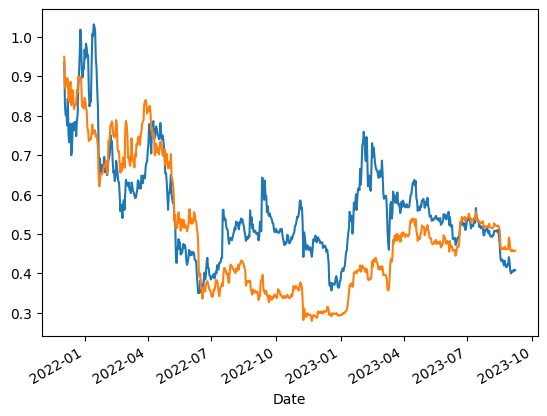

In [16]:
ptf_returns["Bench_returns"] = returns["BTC-USDT_Close"]

ptf_returns = ptf_returns.dropna()
(ptf_returns["portfolio_returns"] + 1).cumprod().plot()
(ptf_returns["Bench_returns"] + 1).cumprod().plot()

In [5]:
ptf_returns, allocations = rolling_portfolio_optimization_backtest(
    returns.drop(columns=["BTC-USDT_Close"]),
    returns["BTC-USDT_Close"],
    100,
    60,
    "Convex",
    "Sharpe ratio",
    "max",
    False,
    True,
)

100%|██████████| 644/644 [03:53<00:00,  2.76it/s]


In [ ]:
# pd.DataFrame(list(map(lambda x :x.values[0], allocations.values())), index=allocations.keys(), columns=tuple(allocations.values())[0].columns)

In [6]:
ptf_returns["Bench_returns"] = returns["BTC-USDT_Close"]

ptf_returns = ptf_returns.dropna()

<Axes: xlabel='Date'>

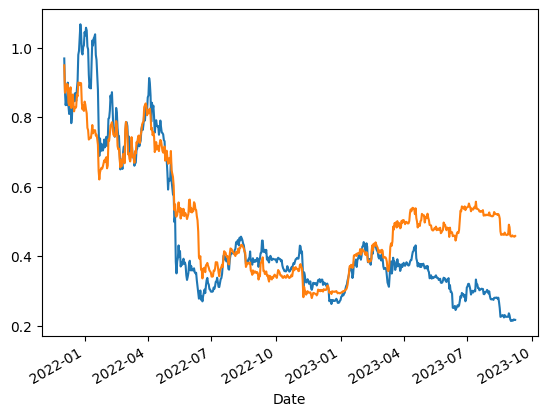

In [7]:
(ptf_returns["portfolio_returns"] + 1).cumprod().plot()
(ptf_returns["Bench_returns"] + 1).cumprod().plot()

# Different optimizers


In [ ]:
# portfolio = MonteCarloPortfolio(returns,returns["BTC-USDT"],"1day")


# portfolio.fit(n_portfolios=200, plot=True)
# portfolio.get_allocation("sharpe", "max")

# Convex process


In [ ]:
ptf = ConvexPortfolio(returns, returns["BTC-USDT_Close"], "1day")
ptf.fit("Sharpe ratio", "max", max_asset_weight=0.2)
ptf.get_allocation()

In [ ]:
rp_ptf = RiskParityPortfolio(returns)
rp_ptf.fit()
rp_ptf.get_allocation()

## CAC40


In [ ]:
import yfinance as yf

cac40_data = yf.download(get_cac40_symbols(), start="2013-01-01", end="2023-03-01")[
    "Adj Close"
]
returns = cac40_data.fillna(method="ffill").pct_change().dropna()
returns

In [ ]:
ptf = ConvexPortfolio(returns)
ptf.fit("sharpe", "max", max_asset_weight=0.2)
alloc = ptf.get_allocation()

# Risk parity optimization


In [ ]:
rp_ptf = RiskParityPortfolio(returns)
rp_ptf.fit()
rp_ptf.get_allocation()

# Native CVXPY


In [ ]:
import cvxpy as cp

cov = returns.cov().to_numpy()
expected_returns = returns.mean().to_numpy()

# set your own parameter: e.g. my expected min return is 0.09% per year
r_min_annualized = 0.09

# create cvxpy variable to minimize
w = cp.Variable(expected_returns.shape[0])
r_min = r_min_annualized / 252

# construct the objective function and constraints
obj = cp.Minimize(w.T @ cov @ w)
const = [cp.sum(w) == 1, w >= 0, w.T @ r - r_min >= 0]

# solve it!
prob = cp.Problem(obj, const)
opt_v = prob.solve()

w_opt = w.values

print(f"Expected return  {252 * (w_opt @ expected_returns)}")
print(f"Expected vol  {(w_opt.T @ cov @ w_opt)*252**0.5}")
print(f"Sharpe  {252 * (w_opt @ expected_returns)/((w_opt.T @ cov @ w_opt)*252**0.5)}")
print("optimal risk (%):", risk_opt)
print("optimal proportion:", np.round(w_opt, 4))

# Genetic algo


In [ ]:
import numpy as np


# Define the fitness function to maximize the Sharpe Ratio
def fitness_function(weights, data):
    data_returns = np.log(data) - np.log(data.shift(1))
    data_returns = data_returns.dropna()

    portfolio_returns = np.dot(data_returns, weights)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
    return sharpe_ratio


# Define the genetic algorithm
def genetic_algorithm(
    data, population_size=200, num_generations=50, mutation_rate=0.05, elitism=0.1
):
    # Initialize the population
    population = np.random.rand(population_size, len(data.columns))
    population = population / np.sum(population, axis=1)[:, np.newaxis]

    # Calculate fitness of initial population
    fitness = np.array(
        [fitness_function(individual, data) for individual in population]
    )

    for generation in range(num_generations):
        # Sort the population by fitness
        sorted_idx = np.argsort(fitness)[::-1]
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]

        # Determine number of individuals to carry over via elitism
        num_elites = int(elitism * population_size)

        # Create the next generation, starting with the elites
        offspring = population[:num_elites]

        # Select parents for reproduction using tournament selection
        parent1_idx = np.random.randint(
            num_elites, population_size, size=population_size - num_elites
        )
        parent2_idx = np.random.randint(
            num_elites, population_size, size=population_size - num_elites
        )
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        # Perform crossover and mutation to create the next generation
        crossover_prob = np.random.rand(population_size - num_elites, len(data.columns))
        crossover_mask = crossover_prob <= 0.5
        offspring_crossover = np.where(crossover_mask, parent1, parent2)

        mutation_prob = np.random.rand(population_size - num_elites, len(data.columns))
        mutation_mask = mutation_prob <= mutation_rate
        mutation_values = np.random.rand(
            population_size - num_elites, len(data.columns)
        )
        mutation_direction = np.random.choice(
            [-1, 1], size=(population_size - num_elites, len(data.columns))
        )
        offspring_mutation = np.where(
            mutation_mask,
            offspring_crossover + mutation_direction * mutation_values,
            offspring_crossover,
        )

        # Ensure the offspring population has valid weights
        offspring_mutation = (
            offspring_mutation / np.sum(offspring_mutation, axis=1)[:, np.newaxis]
        )

        # Combine elites and offspring to create the next generation
        population = np.vstack((population[:num_elites], offspring_mutation))

        # Calculate fitness of new population
        fitness = np.array(
            [fitness_function(individual, data) for individual in population]
        )

    # Return the best individual from the final population
    best_idx = np.argmax(fitness)
    best_individual = population[best_idx]
    print("Best Sharpe Ratio: ", np.max(fitness))

    return best_individual


from datetime import datetime, timedelta

# Seed for reproducibility
np.random.seed(42)


def backtest(genetic_algorithm, data, benchmark, initial_capital):
    # Split the data into training and testing sets
    train_data = data.iloc[:-252]
    test_data = data.iloc[-252:]

    # Run the genetic algorithm on the training set to find the optimal portfolio weights
    weights = genetic_algorithm(
        data=train_data,
        population_size=100,
        num_generations=50,
        mutation_rate=0.01,
        elitism=0.01,
    )
    # print(weights)

    # Set any negative weights to 0
    weights[weights < 0] = 0

    # Normalize remaining positive weights to sum to 1
    weights /= weights.sum()

    # Calculate the returns of the portfolio and the benchmark on the test set
    portfolio_returns = np.dot(test_data.pct_change().dropna(), weights)
    portfolio_cum_returns = np.cumprod(1 + portfolio_returns)
    portfolio_value = initial_capital * portfolio_cum_returns[-1]
    benchmark_returns = benchmark.iloc[-252:].pct_change().dropna()
    benchmark_cum_returns = np.cumprod(1 + benchmark_returns)
    benchmark_value = initial_capital * benchmark_cum_returns[-1]

    # Calculate performance metrics
    portfolio_mean_return = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    portfolio_sharpe_ratio = (portfolio_mean_return / portfolio_std) * np.sqrt(252)
    benchmark_mean_return = np.mean(benchmark_returns)
    benchmark_std = np.std(benchmark_returns)
    benchmark_sharpe_ratio = (benchmark_mean_return / benchmark_std) * np.sqrt(252)

    # print(portfolio_cum_returns)

    # Visualize the performance of the portfolio and the benchmark
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(benchmark_cum_returns.index, portfolio_cum_returns, label="Portfolio")
    ax.plot(benchmark_cum_returns, label="Benchmark")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Returns")
    ax.set_title("Backtesting Results")
    ax.legend()
    plt.show()

    # Print performance metrics
    print("Portfolio Statistics:")
    print("---------------------")
    print("Mean Daily Return: {:.4f}".format(portfolio_mean_return))
    print("Standard Deviation: {:.4f}".format(portfolio_std))
    print("Sharpe Ratio: {:.4f}".format(portfolio_sharpe_ratio))
    print("Final Value: {:.2f}".format(portfolio_value))
    print("")
    print("Benchmark Statistics:")
    print("---------------------")
    print("Mean Daily Return: {:.4f}".format(benchmark_mean_return))
    print("Standard Deviation: {:.4f}".format(benchmark_std))
    print("Sharpe Ratio: {:.4f}".format(benchmark_sharpe_ratio))
    print("Final Value: {:.2f}".format(benchmark_value))

    return (
        portfolio_returns,
        benchmark_returns,
        portfolio_cum_returns,
        benchmark_cum_returns,
    )


(
    portfolio_returns,
    benchmark_returns,
    portfolio_cum_returns,
    benchmark_cum_returns,
) = backtest(genetic_algorithm, data, benchmark, initial_capital=1000)

# Using Riskfolio


In [ ]:
import riskfolio as rp

port = rp.Portfolio(returns=returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu = "hist"  # Method to estimate expected returns based on historical data.
method_cov = "hist"  # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model = "Classic"  # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = "MV"  # Risk measure used, this time will be variance
obj = "Sharpe"  # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True  # Use historical scenarios for risk measures that depend on scenarios
rf = 0  # Risk free rate
l = 0  # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

In [ ]:
points = 50  # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)


label = "Max Risk Adjusted Return Portfolio"  # Title of point
mu = port.mu  # Expected returns
cov = port.cov  # Covariance matrix
returns = port.returns  # Returns of the assets

figure, ax = plt.subplots(1, 2, figsize=(15, 6))


rp.plot_frontier(
    w_frontier=frontier,
    mu=mu,
    cov=cov,
    returns=returns,
    rm=rm,
    rf=rf,
    alpha=0.05,
    cmap="viridis",
    w=w,
    label=label,
    marker="*",
    s=16,
    c="r",
    height=6,
    width=10,
    ax=ax[1],
)


rp.plot_pie(
    w=w,
    title="Sharpe Mean Variance",
    others=0.05,
    nrow=25,
    cmap="tab20",
    height=6,
    width=10,
    ax=ax[0],
)

In [ ]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.
rms = [
    "MV",
    "MAD",
    "MSV",
    "FLPM",
    "SLPM",
    "CVaR",
    "EVaR",
    "WR",
    "MDD",
    "ADD",
    "CDaR",
    "UCI",
    "EDaR",
]

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)

w_s.columns = rms


def filter_unused(x: pd.Series):
    for i in x:
        if i >= 1e-3:
            return True
    return False


w_s = w_s.loc[w_s.apply(filter_unused, axis=1)]
w_s.style.format("{:.2%}").background_gradient(cmap="YlGn")

## Comparing each portfolio


In [ ]:
fig = plt.gcf()
fig.set_figwidth(15)
fig.set_figheight(5)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

# Using empyrical


In [ ]:
from empyrial import empyrial, Engine

portfolio = Engine(
    start_date="2018-01-01",  # start date for the backtesting
    portfolio=[
        "IRCTC.NS",
        "RELIANCE.NS",
        "INFY.NS",
        "HDFCBANK.NS",
    ],  # assets in your portfolio
    weights=[0.2, 0.2, 0.2, 0.2],  # equal weighting is set by default
    benchmark=["^NSEI"],  # SPY is set by default
)

empyrial(portfolio)